# Convolutional Neural Networks - CIFAR10 (By Shiza Charania)
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='https://production-media.paperswithcode.com/datasets/CIFAR-10-0000000431-b71f61c0_U5n3Glr.jpg' width=50% height=50% />

---
## Downloading and Loading the Data

In [1]:
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import transforms

batch_size = 10

transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

#first download the datasets
trainset = datasets.CIFAR10(root="data", train=True, transform=transforms, download=True)
testset = datasets.CIFAR10(root="data", train=False, transform=transforms, download=True)

#split up from indices from the training data --> for the training and validation sets
dataset_len = len(trainset)
indices = list(range(dataset_len))
len_trainset = int(dataset_len * 0.8)

train_idx = torch.utils.data.SubsetRandomSampler(indices[:len_trainset])
validation_idx = torch.utils.data.SubsetRandomSampler(indices[len_trainset:])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_idx)
validationloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=validation_idx)
testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# the image classes - will also be used later when checking the accuracy for each class
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


### Visualizing a Batch of Training Data

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# function to un-normalize and display an image
def imshow(img):
    img = img / 1 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image to numpy image type
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


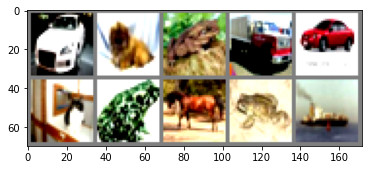

In [5]:
images, labels = next(iter(trainloader))

imshow(torchvision.utils.make_grid(images[0:10], nrow= 5))

---
## Defining the Network Architecture

In [6]:
import torch.nn as nn
import torch.nn.functional as F


model = nn.Sequential(
    # convolutional layer (sees 32x32x3 image tensor)
    nn.Conv2d(3, 16, 3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    # convolutional layer (sees 16x16x16 image tensor)
    nn.Conv2d(16, 32, 3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    # convolutional layer (sees 8x8x3 image tensor)
    nn.Conv2d(32, 64, 3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    # now it sees a 4x4x64 image
    nn.Flatten(), #1024
    #fully connected layers
    nn.Linear(1024, 500),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.Linear(500, 10),
    nn.Softmax()
)

In [7]:
print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=1024, out_features=500, bias=True)
  (11): ReLU()
  (12): Dropout(p=0.25, inplace=False)
  (13): Linear(in_features=500, out_features=10, bias=True)
  (14): Softmax(dim=None)
)


### Specifying a Loss Function and Optimizer

In [41]:
from torch import optim

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=0.01)

---
## Training the Network

In [42]:
epochs = 30

ttlosses = []
tvlosses = []

for i in range(epochs):
    #training the model
    training_loss = 0
    validation_loss = 0
    model.train()
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()

    model.eval()
    #validation set
    for images, labels in validationloader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        validation_loss += loss.item()

    total_training_loss = (training_loss/len(trainloader.sampler)) #add sampler here because it gives the right # for the length (40000)
    total_validation_loss = (validation_loss/len(validationloader.sampler))

    ttlosses.append(total_training_loss)
    tvlosses.append(total_validation_loss)

    print("Epoch: {}/{}...".format(i+1,epochs),
        "Training loss: {:.4f}...".format(total_training_loss), 
        "Validation loss: {:.4f}...".format(total_validation_loss))

    if tvlosses[-1] <= min(tvlosses): # u also but "=" for the first epoch to save
        print("Validation loss decreased - saving model...")
        torch.save(model.state_dict(), "model_cifar.pth") #this saves the weights and biases of the model whenever the validation loss decreases

Epoch: 1/30... Training loss: 0.2302... Validation loss: 0.2302...
Validation loss decreased - saving model...
Epoch: 2/30... Training loss: 0.2300... Validation loss: 0.2294...
Validation loss decreased - saving model...
Epoch: 3/30... Training loss: 0.2220... Validation loss: 0.2170...
Validation loss decreased - saving model...
Epoch: 4/30... Training loss: 0.2146... Validation loss: 0.2124...
Validation loss decreased - saving model...
Epoch: 5/30... Training loss: 0.2106... Validation loss: 0.2080...
Validation loss decreased - saving model...
Epoch: 6/30... Training loss: 0.2071... Validation loss: 0.2047...
Validation loss decreased - saving model...
Epoch: 7/30... Training loss: 0.2045... Validation loss: 0.2028...
Validation loss decreased - saving model...
Epoch: 8/30... Training loss: 0.2024... Validation loss: 0.2013...
Validation loss decreased - saving model...
Epoch: 9/30... Training loss: 0.2005... Validation loss: 0.1990...
Validation loss decreased - saving model...
E

###  Loading the Model with the Lowest Validation Loss

Visualize the losses


In [43]:
loaded_model = torch.load("model_cifar.pth")
model.load_state_dict(loaded_model)

<All keys matched successfully>

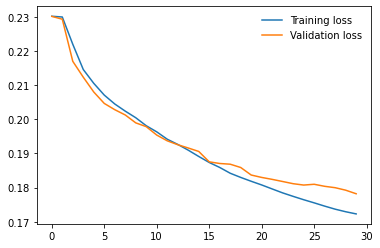

In [44]:
plt.plot(ttlosses, label="Training loss")
plt.plot(tvlosses, label="Validation loss")
plt.legend(frameon=False)

---
## Testing the Trained Network

In [45]:
test_loss = 0
class_correct = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
class_total = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# testing
for images, labels in trainloader:
    torch.no_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    test_loss += loss.item()
    ps = torch.exp(outputs)
    _, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*np.shape(top_class)) #set as true or false
    equals_squeezed = np.squeeze(equals.numpy()) # squeezes all the true false statements into one [] instead of a tensor with [True] and [False] for each
    
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = labels.data[i] #where in the data (index-wise) is this image-label pair
        class_correct[label] += equals_squeezed[i].item() #takes the True or False statement in that part of the squeezed sequence and adds it to the class_correct list
        #^my question about this is that: how is True set to the number one and False set to the number 0? Before we used: equals.type(torch.FloatTensor)
        class_total[label] += 1 #increases 1 for the # of items for that class

# average test loss
test_loss = test_loss/len(testloader)
print("Testing loss: {:.2f}".format(test_loss))

# each class's accuracy
for i in range(10):
    print("Accuracy of {}: {:.1f}% ({}/{})".format(classes[i], 100 * class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))

# overall test accuracy
print("Test Accuracy Overall: {:.1f}%    ({}/{})".format(np.sum(class_correct)/np.sum(class_total)*100, np.sum(class_correct), np.sum(class_total)))

Testing loss: 1.35
Accuracy of airplane: 83.4% (3323/3986)
Accuracy of automobile: 86.9% (3465/3986)
Accuracy of bird: 67.2% (2722/4048)
Accuracy of cat: 67.7% (2696/3984)
Accuracy of deer: 72.7% (2909/4003)
Accuracy of dog: 67.5% (2685/3975)
Accuracy of frog: 82.0% (3296/4020)
Accuracy of horse: 82.8% (3331/4023)
Accuracy of ship: 88.7% (3544/3997)
Accuracy of truck: 84.8% (3373/3978)
Test Accuracy Overall: 78.4%    (31344/40000)
